# Monthly mean house prices in DC by zipcode

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from get_data import *
dc_df_T = get_the_data()
zipcodes = list(dc_df_T.columns)

dc_df_T.head()

,20002,20009,20011,20019,20001,20020,20008,20003,20032,20016,20010,20007,20024,20017,20018,20037,20015,20012
date,,,,,,,,,,,,,,,,,,
1996-04-01,94300.0,178800.0,118900.0,91300.0,92000.0,104500.0,450100.0,130000.0,85700.0,362000.0,110500.0,358100.0,209800.0,121700.0,123000.0,277800.0,312400.0,185000.0
1996-05-01,94000.0,179200.0,118500.0,91000.0,92600.0,103800.0,448200.0,130100.0,85500.0,361200.0,111200.0,356000.0,208200.0,121400.0,122400.0,275800.0,311000.0,184900.0
1996-06-01,93700.0,179600.0,118200.0,90600.0,93200.0,103000.0,446300.0,130200.0,85400.0,360300.0,112000.0,353900.0,206600.0,121200.0,121800.0,273700.0,309800.0,184700.0
1996-07-01,93600.0,180000.0,117800.0,90400.0,93900.0,102200.0,444500.0,130400.0,85200.0,359400.0,112900.0,351700.0,205000.0,121000.0,121200.0,271600.0,308700.0,184400.0
1996-08-01,93400.0,180300.0,117600.0,90100.0,94600.0,101400.0,442900.0,130600.0,85000.0,358500.0,113800.0,349600.0,203300.0,120900.0,120700.0,269500.0,307900.0,184100.0


In [3]:
pd.set_option('display.max_columns', 500)
import matplotlib 

import matplotlib.pyplot as plt
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
plt.rcParams['figure.figsize'] = 12, 6

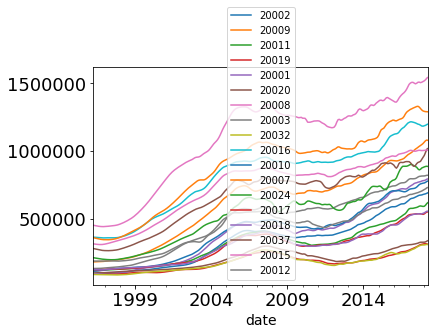

In [4]:
# check for NA
dc_df_T.plot()

# Can we predict housing prices?

In [5]:
from all_the_functions import *

Start with one zipcode: 20002

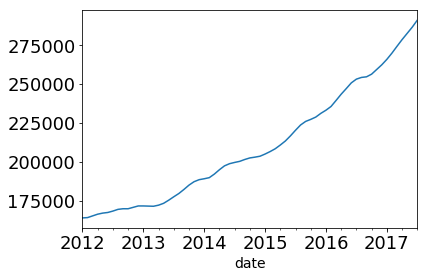

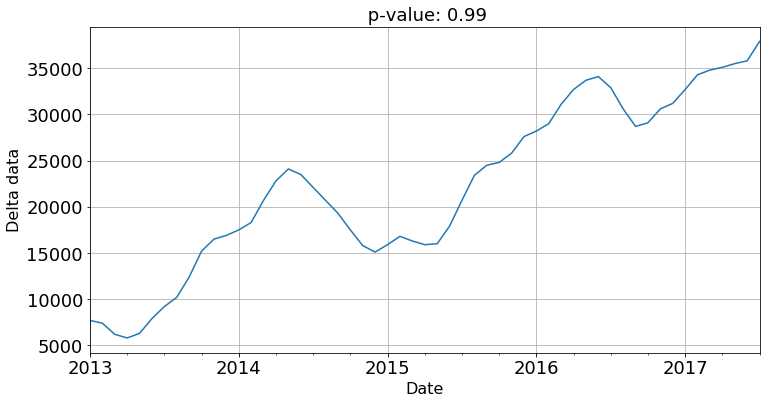

In [6]:
data = dc_df_T.loc['2012-01-01':'2017-07-1'][20019]


data.plot()

data_roll_mean = data.shift(12)

pval = Compare_Transformations(data, data_roll_mean)

Plot_Compare(data, data_roll_mean)


Now apply to all the zipcodes

In [ ]:
results = []
train_data = []
test_data =[]
pdq_params = []
seasonal_pdq_params = []

for zipcode in zipcodes:
    time_start = '2012'
    time_cut = '2017-07'
    y = dc_df_T[zipcode].resample('MS').mean()
    y_train = y[time_start:time_cut]

    y_test = y[time_cut:]
    y_test = y_test[1:]
    
    # make it stationary
    name, pvalue, ybest_data = Trend_elimination(y_train)    
    print("{} The best data is the '{}' data set \npvalue:{}".format(zipcode, name, pvalue))
    
    # Get the Parameters on the difference between y and ybest
    y_diff = y_train - ybest_data
    y_diff.dropna(inplace=True)
    p_params = Get_p_params(y_diff)
    q_params = Get_q_params(y_diff)
    
    # Fit the MODEL
    model, best_order, best_seasonal_order = Get_Best_Model(y_train,
                                                        p_params,
                                                        q_params)
    
    result = model.fit()
    results.append(result)
    train_data.append(y_train)
    test_data.append(y_test)
    pdq_params.append(best_order)
    seasonal_pdq_params.append(best_seasonal_order)

20002 The best data is the 'rolling_mean_data' data set 
pvalue:0.03039488062411294


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [ ]:
from sklearn import metrics

profit = []
percent = []
for model in results:
    pred = model.get_prediction(start=pd.to_datetime('2018-04'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    profit.append(pred.predicted_mean[-1] - pred.predicted_mean[0])
    percent.append(pred.predicted_mean[-1]/pred.predicted_mean[0]-1)
    
root_mean = []
r2 = []
for model in results:
    pred = model.get_prediction(start=pd.to_datetime('2017-08-01'),
                              end=pd.to_datetime('2018-04-01'),
                             dynamic=True)
    root_mean.append(np.sqrt(metrics.mean_squared_error(test_data[0], pred.predicted_mean)))
    r2.append(metrics.r2_score(test_data[0], pred.predicted_mean))

In [ ]:
df_profits = pd.DataFrame({'zipcode': zipcodes, 'profit': profit, 'percent': percent, 'rmse': root_mean, 'r2': r2})
df_profits

In [ ]:
for i, val in enumerate(zipcodes):
    Make_PredictionPlot(results[i], train_data[i], test_data[i], val, time_cut, print_test=True)

In [ ]:
from sklearn import metrics

root_mean = []
r2 = []
for i,model in enumerate(results):
    pred = model.get_prediction(start=(pd.to_datetime(time_cut) + pd.DateOffset(months=1)),
                              end=pd.to_datetime('2018-04-01'),
                             dynamic=True)
    root_mean.append(np.sqrt(metrics.mean_squared_error(test_data[i], pred.predicted_mean)))
    r2.append(metrics.r2_score(test_data[i], pred.predicted_mean))
print(pred)
print(root_mean)
print(r2)

In [ ]:
plt.scatter(root_mean, r2)
plt.grid(True)

In [ ]:
best_zipcodes=[]
for i,model in enumerate(results):
    if(r2[i]>0 and root_mean[i]<10000):
        print(zipcodes[i])

In [ ]:
final_zipcodes = []
final_results = []
final_train_data = []
final_test_data =[]
final_pdq_params = []
final_seasonal_pdq_params = []
time_start = '2012'
time_cut = '2018-04'


for i,model in enumerate(results):
    if(r2[i]>0 and root_mean[i]<10000):  

        zipcode = zipcodes[i]
        final_zipcodes.append(zipcode)
        y = dc_df_T[zipcode].resample('MS').mean()
        y_train = y[time_start:time_cut]

        y_test = y[time_cut:]
        y_test = y_test[1:]
    

        p_params = pdq_params[i]
        q_params = seasonal_pdq_params[i]
    
        # Fit the MODEL with the best parameters
        print(q_params)
        model = sm.tsa.statespace.SARIMAX(y_train,
                                        order=p_params,
                                        seasonal_order=q_params,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        result = model.fit()
        final_results.append(result)
        final_train_data.append(y_train)
        final_test_data.append(y_test)
        final_pdq_params.append(best_order)
        final_seasonal_pdq_params.append(best_seasonal_order)

In [ ]:
for i, val in enumerate(final_zipcodes):

    Make_PredictionPlot(final_results[i], final_train_data[i], 
                        final_test_data[i], val,time_cut, print_test=False)

In [ ]:
profit = []
percent = []
profit_error = []

for model in final_results:
    pred = model.get_prediction(start=pd.to_datetime('2018-04'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    pred_ci = pred.conf_int()
    
    error_A = (pred_ci.iloc[0,1] - pred_ci.iloc[0,0])/2
    error_B = (pred_ci.iloc[-1,1] - pred_ci.iloc[-1,0])/2
    error_profit = np.sqrt(error_A**2 + error_B**2)
    
    profit.append(pred.predicted_mean[-1] - pred.predicted_mean[0])
    percent.append(pred.predicted_mean[-1]/pred.predicted_mean[0]-1)
    profit_error.append(error_profit)

In [ ]:
df_pred = pd.DataFrame({'zipcode':final_zipcodes,'profit':profit, 'percent': percent, "profit_error": profit_error}) 

In [ ]:
df_pred.sort_values(by='worst_case', ascending=False)

In [ ]:
df_pred['worst_case'] = df_pred['profit'] - df_pred['profit_error']
df_pred['best_case'] = df_pred['profit'] + df_pred['profit_error']


In [ ]:
pred_ci

In [ ]:
error_A = (pred_ci.iloc[0,1]  -pred_ci.iloc[0,0])/2

In [ ]:
error_B = (pred_ci.iloc[-1,1]  -pred_ci.iloc[-1,0])/2

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
# auto_acf = acf(y_diff)

# plot(auto_acf)
plot_acf(y_diff,alpha=0.0001);
# acf, conf_int = sm.tsa.acf(y_diff, confint=0.95)
acfvals , acf_conf=  sm.tsa.acf(y_diff, alpha=0.0001)
# print(acf(y_diff, confint=95))
# pacf(y_diff,confint=95)

In [ ]:
acfvals